# Inspect $r_i^2/var_i$ for Results that Differ Only in $R^2$ or $\rho$

<hr/>

#### Imports

In [1]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from ensemble_uncertainties.utils.ad_assessment import spearman_coeff

from sklearn.metrics import r2_score

#### Constants

In [2]:
N_REPETITIONS = 100
N_SPLITS = 2
DATA_FOLDER = '../../../data/featurized/'
RESULT_FOLDER = '../../../data/results/kfold_ensembles/'
PLOT_FOLDER = './plots/'
ALLOWED_RANGE_FACTOR = .5

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200

# Current
algorithms = ['rf', 'xgb', 'svm_rbf', 'shallow', 'dropout']
algorithm_to_name = {'rf' : 'RF', 'xgb' : 'XGB', 'svm_rbf' : 'SVM', 'shallow' : 'Shallow', 'dropout' : 'Deep'}

descriptors = ['maccs', 'ecfc', 'rdkit', 'cddd']
descriptor_to_name = {'maccs' : 'MACCS', 'ecfc' : 'MFC', 'rdkit' : 'RDKit', 'cddd' : 'CDDD'}

# Names of the datasets that were already run
dataset_names = [
    'tetrahymena',
    'freesolv',
    'esol',
    'MMP2',
    'IL4',
    'F7',
    'O60674',
    'O14965',
    'P03372',
    'P04150',
    'P06401',
    'P11229',
    'P12931',
    'P16581',
    'P17252',
    'P18089',
    'P19327',
    'P21554',
    'P24530',
    'P25929',
    'P28335',
    'P28482',
    'P35968',
    'P41594',
    'P42345',
    'P47871',
    'P49146',
    'P61169',
    'Q05397',
    'Q16602',
    'P24941',
    'Q92731'
]

#### Functions

In [4]:
def load_results_file(name, algorithm, descriptor, n_repetitions=N_REPETITIONS, n_splits=N_SPLITS):
    """Loads results from disk for a given combination of ML settings."""
    path = f'{RESULT_FOLDER}{name}/{algorithm}/{descriptor}/single_predictions/test.csv'
    results = pd.read_csv(path, sep=';').set_index('id')
    single_tables = list()
    for i in range(n_repetitions):
        partial_results = results[[f'rep{i}_split{j}' for j in range(n_splits)]]
        single_tables.append(partial_results)
    return single_tables


def load_true(name):
    """Loads dependent variables of a given dataset."""
    path = f'{DATA_FOLDER}{name}/{name}_y.csv'
    y = pd.read_csv(path, sep=';').set_index('id')
    return y


def harmonize(values):
    """Subtracts smallest value and divides by largest, so all values will be in [0, 1]."""
    floored_values = values - values.min()
    scaled_floored_values = floored_values / floored_values.max()
    return scaled_floored_values


def cumulative_predictive_performance(single_tables, y):
    """Computes the change in R^2 when taking more and more ensemble members into account."""
    members = pd.DataFrame(index=y.index)
    scores = list()
    for i, member in enumerate(single_tables):
        members = pd.concat([members, member], axis=1)
        mean = members.mean(axis=1)
        scores.append(r2_score(y['y'], mean.values))
    scores = np.array(scores)
    return scores


def clean_member(member_raw, y):
    """Removes predictions that are outside the allowed y-range"""
    member = copy.deepcopy(member_raw)
    for column in member.columns:
        # To the current column, those indeces
        # that are nan belong to training samples
        train_y = y.loc[member[~member[column].isnull()].index]
        train_y_range = train_y.max() - train_y.min()
        boundary = ALLOWED_RANGE_FACTOR * train_y_range
        allowed_min = (train_y.min() - boundary).values[0]
        allowed_max = (train_y.max() + boundary).values[0]
        exclusion = ((member[column] < allowed_min) | (member[column] > allowed_max))
        member.loc[exclusion] = np.nan
    return member


def compute_ratios(name, algorithm, descriptor, mode='normal'):
    """Yields bias**2/var for a dataset/algorithm/featurization combination."""
    y = load_true(name)
    pre_members = load_results_file(name, algorithm, descriptor)
    members = [clean_member(member, y) for member in pre_members]
    mean = pd.concat(members, axis=1).mean(axis=1).reindex(y['y'].index)
    var = pd.concat(members, axis=1).var(axis=1).reindex(y['y'].index)
    resid = y['y'] - mean
    bias_squared = resid**2
    ratio = bias_squared / var
    r2 = r2_score(y['y'], mean)
    rho = spearman_coeff(resid, var)
    if mode == 'normal':
        pass
    else:
        ratio = mode(ratio)
    return ratio, r2, rho


def plot_hist_for_combination(name, algorithm, descriptor, bins=None, title=None, path=None, mode='normal', ylim=None):
    """bias**2/var histogram for a given dataset/algorithm/featurization combination."""
    ratios, r2, rho = compute_ratios(name, algorithm, descriptor, mode=mode)
    plt.grid(zorder=1000)
    if bins is not None:
        _, bins, _ = plt.hist(ratios, bins=bins, zorder=100, label=None)
    else:
        _, bins, _ = plt.hist(ratios, bins=100, zorder=100, label=None)
    plt.scatter([], [], alpha=.0, label='$R^2$ = ' + f'{r2:.3f}\n' + r'$\rho$ = ' + f'{rho:.3f}\n')
    if title:
        plt.title(title)
    if mode == 'normal':
        plt.xlabel('Ratio ($r_i^2\ / \ \mathrm{var}_i$)')
    else:
        transformator_name = str(mode).split("\'")[1]
        plt.xlabel(f'{transformator_name}' + '($r_i^2\ / \ \mathrm{var}_i$)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    if ylim:
        plt.ylim(ylim)
    if path:
        plt.savefig(path, bbox_inches='tight', pad_inches=0.01)        
    plt.show()
    return bins

<hr/>

#### Evaluate (plot histograms of ratios and histograms of sqrt(ratios))

Cases of equal $R^2$ but varying $\rho$:

ESOL SVM/RDKit and Shallow/ECFC

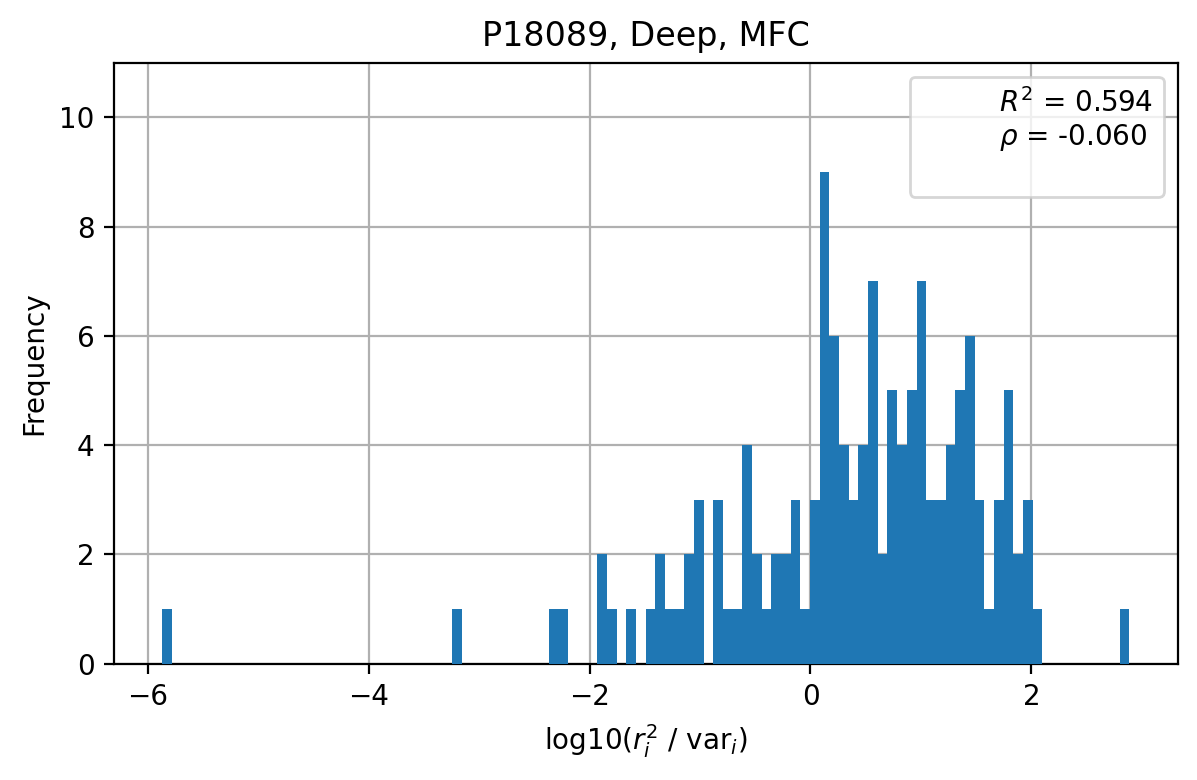

In [5]:
# log10 first

bins = plot_hist_for_combination(
    'P18089',
    'dropout',
    'ecfc',
    title='P18089, Deep, MFC',
    path=PLOT_FOLDER+'P18089_deep_mfc_log10.pdf',
    mode=np.log10,
    ylim=(0, 11)
)

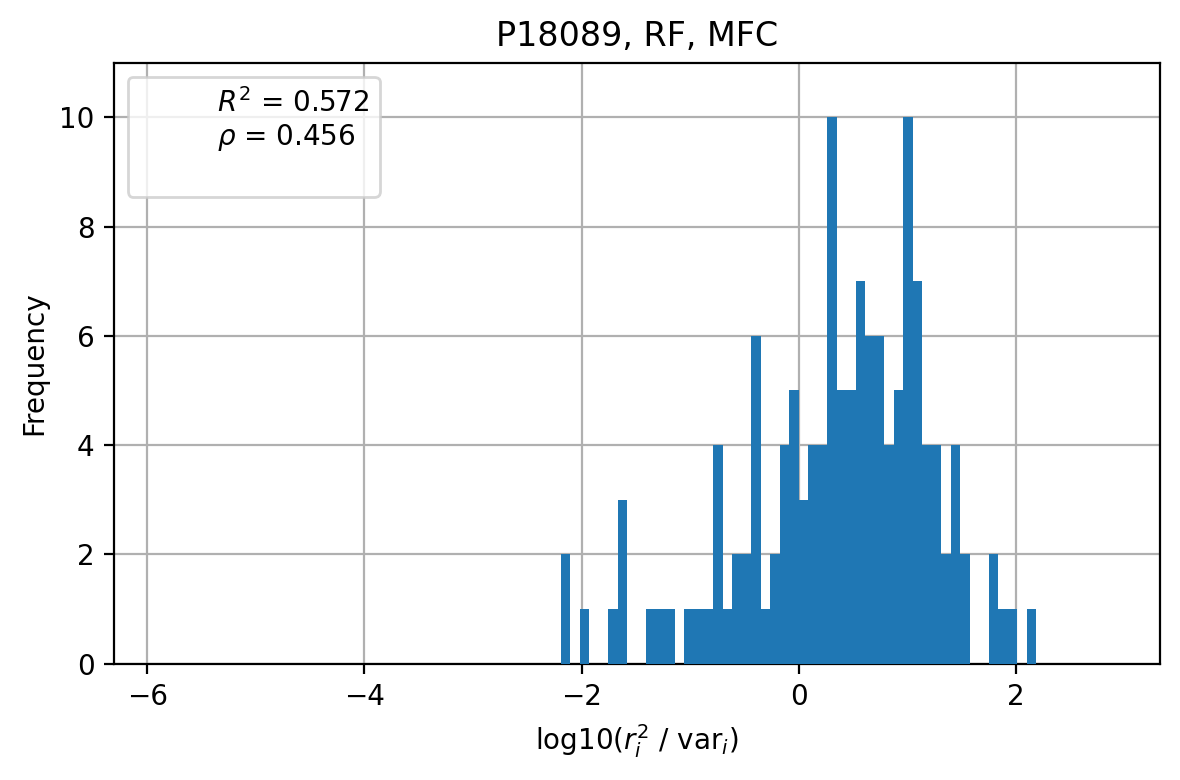

In [6]:
# log10 second

bins = plot_hist_for_combination(
    'P18089',
    'rf',
    'ecfc',
    bins=bins,
    title='P18089, RF, MFC',
    path=PLOT_FOLDER+'P18089_RF_mfc_log10.pdf',
    mode=np.log10,
    ylim=(0, 11)
)

Both log10s above each other

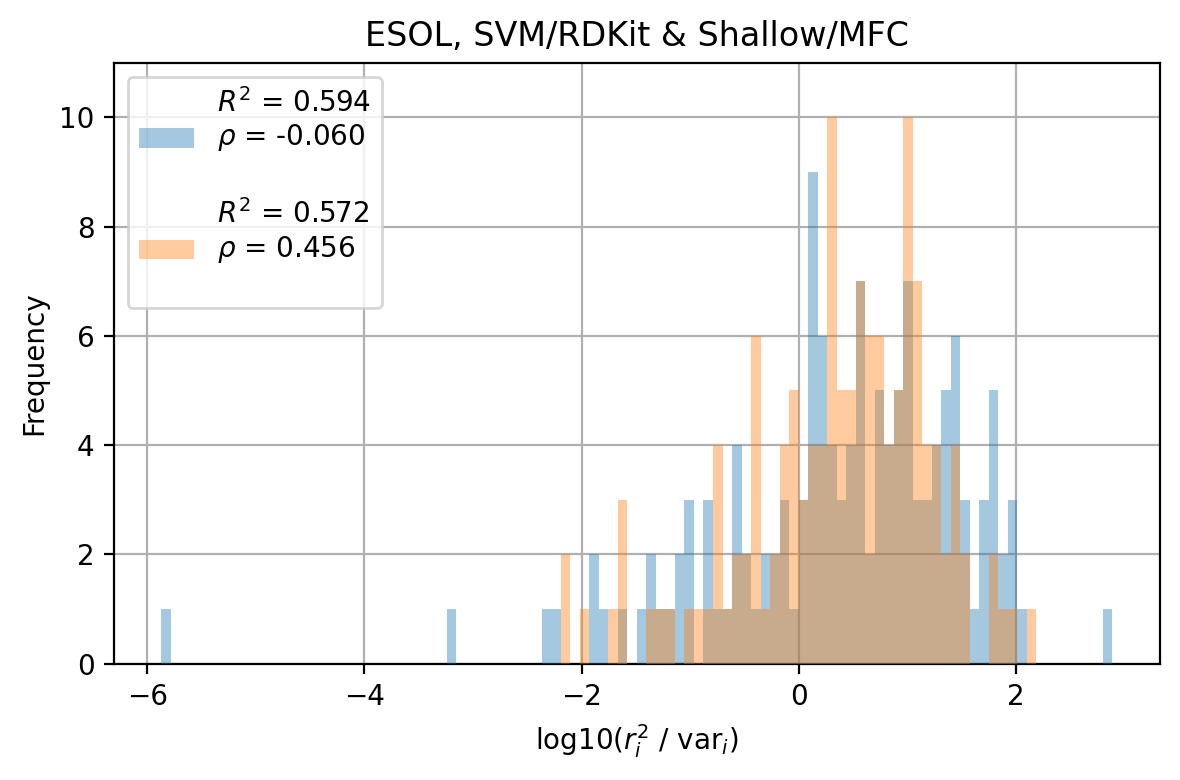

In [7]:
mode = np.log10
plt.grid(zorder=1000)
ratios1, r21, rho1 = compute_ratios('P18089', 'dropout', 'ecfc', mode=mode)
_, bins, _ = plt.hist(ratios1, bins=100, zorder=100, label='$R^2$ = ' + f'{r21:.3f}\n' + r'$\rho$ = ' + f'{rho1:.3f}\n', color='C0', alpha=.4)
#plt.scatter([], [], alpha=.0, label='$R^2$ = ' + f'{r21:.3f}\n' + r'$\rho$ = ' + f'{rho1:.3f}\n', color='C0')
ratios2, r22, rho2 = compute_ratios('P18089', 'rf', 'ecfc', mode=mode)
plt.hist(ratios2, bins=bins, zorder=100, label='$R^2$ = ' + f'{r22:.3f}\n' + r'$\rho$ = ' + f'{rho2:.3f}\n', color='C1', alpha=.4)
#plt.scatter([], [], alpha=.0, label='$R^2$ = ' + f'{r22:.3f}\n' + r'$\rho$ = ' + f'{rho2:.3f}\n', color='C1')
plt.title('ESOL, SVM/RDKit & Shallow/MFC')
transformator_name = str(mode).split("\'")[1]
plt.xlabel(f'{transformator_name}' + '($r_i^2\ / \ \mathrm{var}_i$)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.ylim((0, 11))
plt.savefig(PLOT_FOLDER+'P18089_dropout_mfc_and_rf_mfc_log10.pdf', bbox_inches='tight', pad_inches=0.01)        
plt.show()

High $\rho$, varying $R^2$:

FreeSolv, SVM/MFC and Shallow/MFC

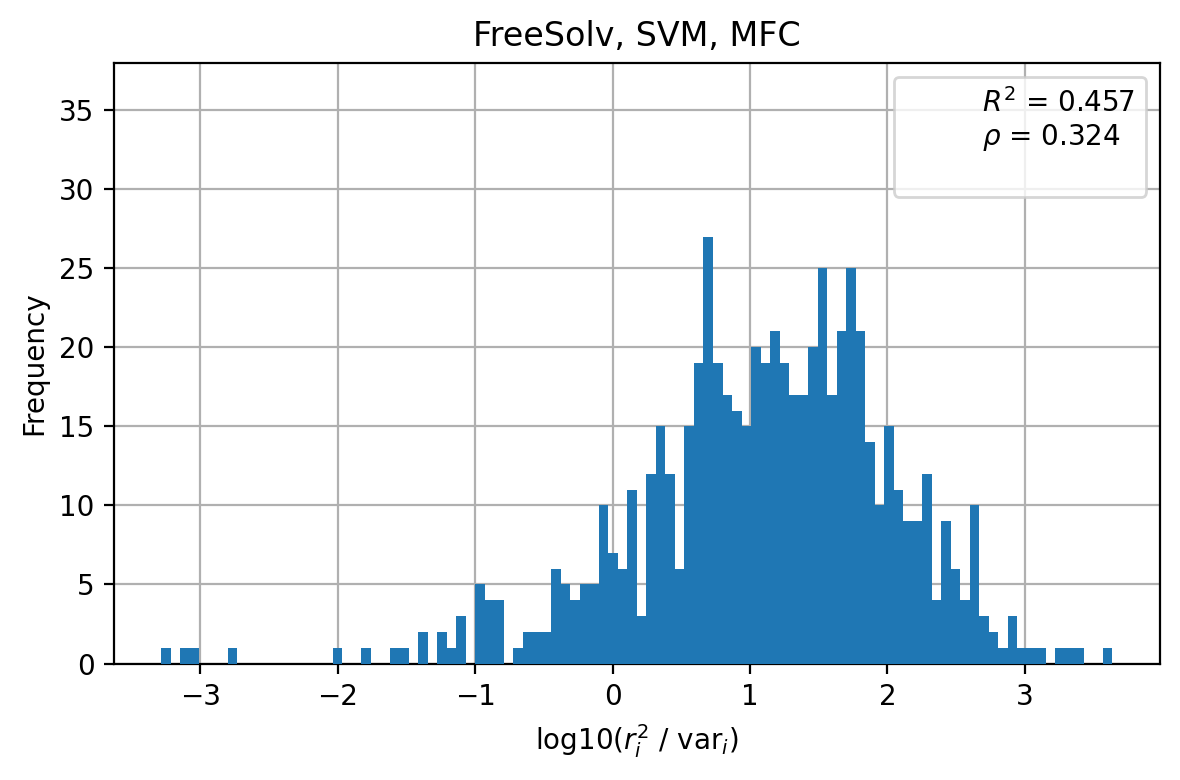

In [8]:
# log10 first

bins = plot_hist_for_combination(
    'freesolv',
    'svm_rbf',
    'ecfc',
    title='FreeSolv, SVM, MFC',
    path=PLOT_FOLDER+'freesolv_svm_mfc_log10.pdf',
    mode=np.log10,
    ylim=(0, 38)
)

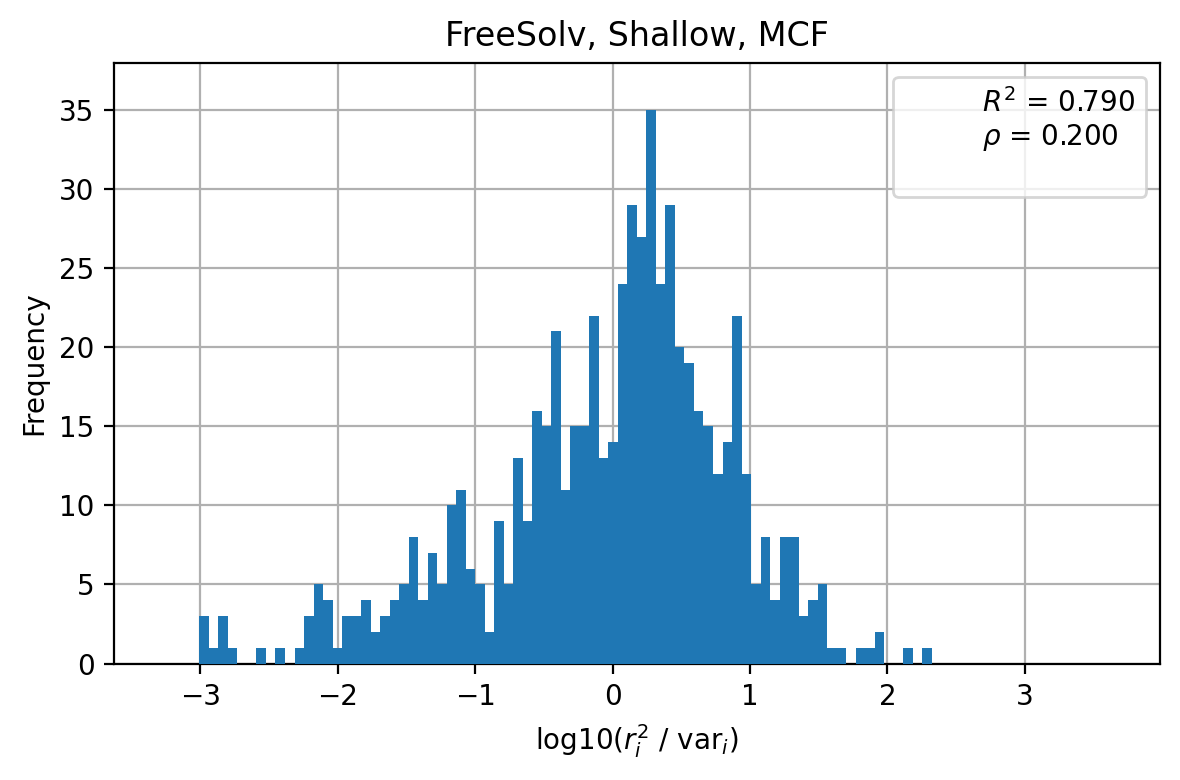

In [9]:
# log10 second

bins = plot_hist_for_combination(
    'freesolv',
    'shallow',
    'ecfc',
    bins=bins,
    title='FreeSolv, Shallow, MCF',
    path=PLOT_FOLDER+'freesolv_shallow_mfc_log10.pdf',
    mode=np.log10,
    ylim=(0, 38)
)

Both logs10s above each other

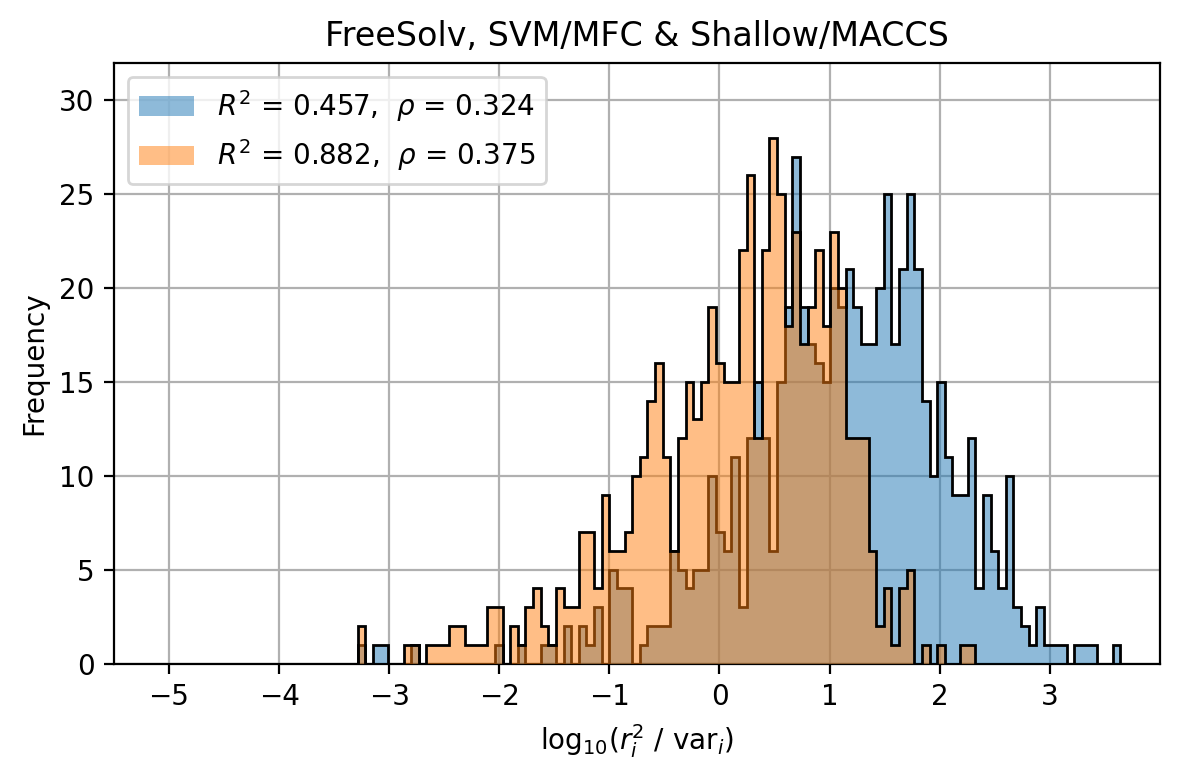

In [10]:
mode = np.log10
plt.grid(zorder=1000)
ratios1, r21, rho1 = compute_ratios('freesolv', 'svm_rbf', 'ecfc', mode=mode)
_, bins, _ = plt.hist(ratios1, bins=100, zorder=100, 
                      label='$R^2$ = ' + f'{r21:.3f},  ' + r'$\rho$ = ' + f'{rho1:.3f}', color='C0', alpha=.5,)
plt.hist(ratios1, bins=bins, zorder=100, color='k', alpha=1, histtype=u'step')
ratios2, r22, rho2 = compute_ratios('freesolv', 'shallow', 'maccs', mode=mode)
plt.hist(ratios2, bins=bins, zorder=100,
         label='$R^2$ = ' + f'{r22:.3f},  ' + r'$\rho$ = ' + f'{rho2:.3f}', color='C1', alpha=.5)
plt.hist(ratios2, bins=bins, zorder=100, color='k', alpha=1, histtype=u'step')
plt.title('FreeSolv, SVM/MFC & Shallow/MACCS')
transformator_name = str(mode).split("\'")[1]
plt.xlabel('$\mathrm{log}_{10}$($r_i^2\ / \ \mathrm{var}_i$)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.xlim((-5.5, 4))
plt.ylim((0, 32))
plt.xticks(range(-5, 4))
plt.savefig(PLOT_FOLDER+'freesolv_svm_mfc_and_shallow_maccs_log10.pdf', bbox_inches='tight', pad_inches=0.01)        
plt.show()

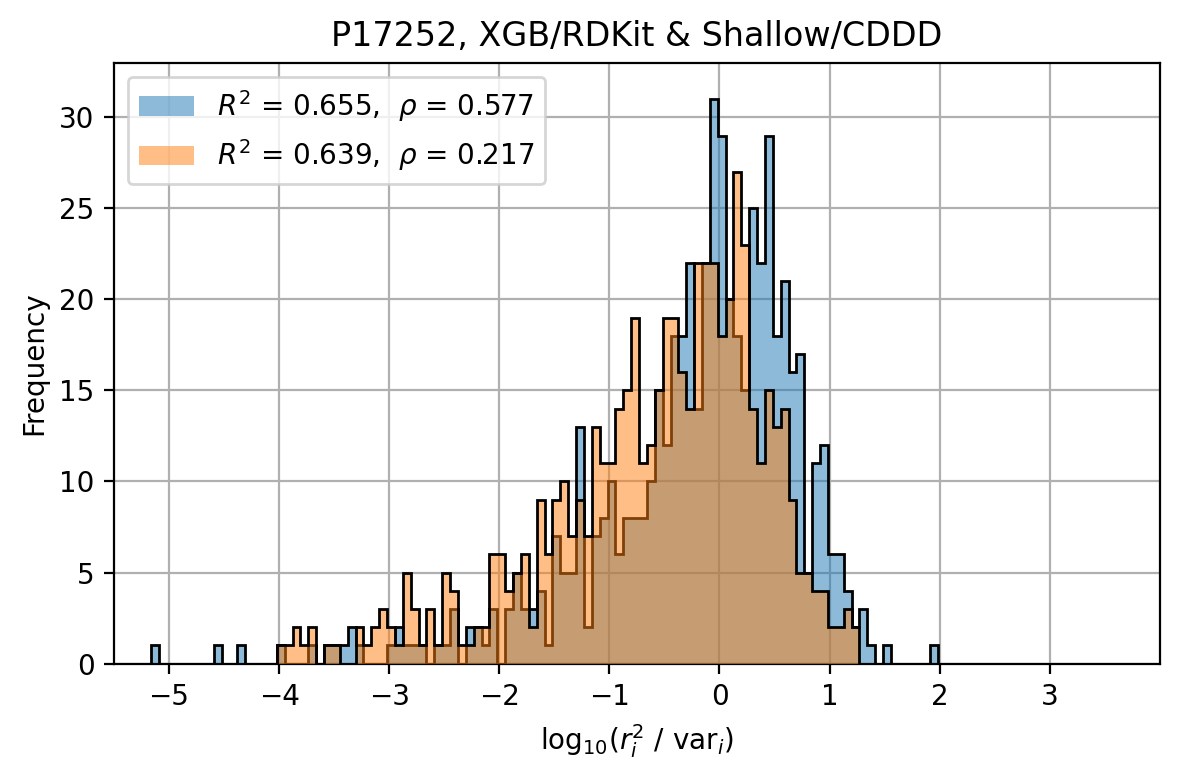

In [11]:
mode = np.log10
plt.grid(zorder=1000)
ratios1, r21, rho1 = compute_ratios('P17252', 'xgb', 'rdkit', mode=mode)
_, bins, _ = plt.hist(ratios1, bins=100, zorder=100, 
                      label='$R^2$ = ' + f'{r21:.3f},  ' + r'$\rho$ = ' + f'{rho1:.3f}', color='C0', alpha=.5,)
plt.hist(ratios1, bins=bins, zorder=100, color='k', alpha=1, histtype=u'step')
ratios2, r22, rho2 = compute_ratios('P17252', 'shallow', 'cddd', mode=mode)
plt.hist(ratios2, bins=bins, zorder=100,
         label='$R^2$ = ' + f'{r22:.3f},  ' + r'$\rho$ = ' + f'{rho2:.3f}', color='C1', alpha=.5)
plt.hist(ratios2, bins=bins, zorder=100, color='k', alpha=1, histtype=u'step')
plt.title('P17252, XGB/RDKit & Shallow/CDDD')
transformator_name = str(mode).split("\'")[1]
plt.xlabel('$\mathrm{log}_{10}$($r_i^2\ / \ \mathrm{var}_i$)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.xlim((-5.5, 4))
plt.ylim((0, 33))
plt.xticks(range(-5, 4))
plt.savefig(PLOT_FOLDER+'P17252_xgb_rdkit_and_shallow_cddd_log10.pdf', bbox_inches='tight', pad_inches=0.01)        
plt.show()

Plot next to each other

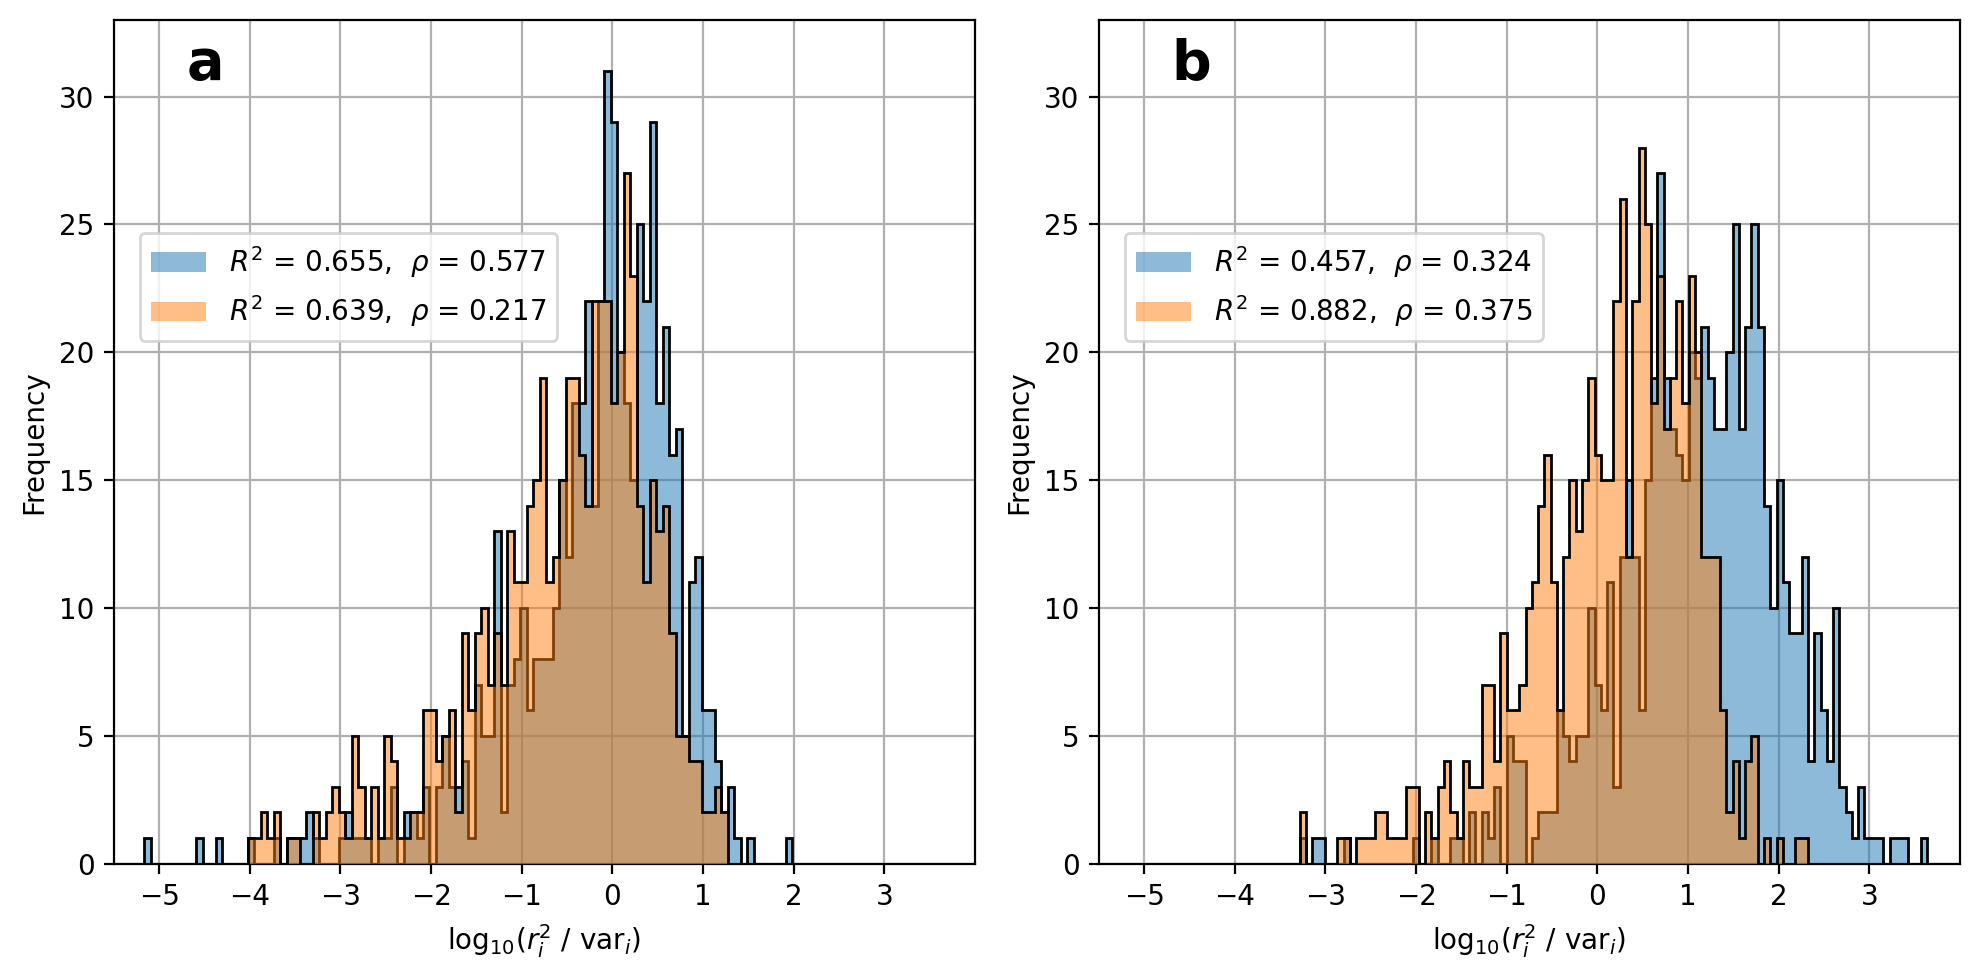

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
image_path = f'{PLOT_FOLDER}comparison_for_publication.pdf'

ax1.grid(zorder=1000)
ratios1, r21, rho1 = compute_ratios('P17252', 'xgb', 'rdkit', mode=mode)
_, bins, _ = ax1.hist(ratios1, bins=100, zorder=100, label='$R^2$ = ' + f'{r21:.3f},  ' + r'$\rho$ = ' + f'{rho1:.3f}', color='C0', alpha=.5,)
ax1.hist(ratios1, bins=bins, zorder=100, color='k', alpha=1, histtype=u'step')
ratios2, r22, rho2 = compute_ratios('P17252', 'shallow', 'cddd', mode=mode)
ax1.hist(ratios2, bins=bins, zorder=100, label='$R^2$ = ' + f'{r22:.3f},  ' + r'$\rho$ = ' + f'{rho2:.3f}', color='C1', alpha=.5)
ax1.hist(ratios2, bins=bins, zorder=100, color='k', alpha=1, histtype=u'step')
ax1.set_xlabel('$\mathrm{log}_{10}$($r_i^2\ / \ \mathrm{var}_i$)')
ax1.set_ylabel('Frequency')
ax1.set_xlim((-5.5, 4))
ax1.set_xticks(range(-5, 4))
ax1.set_ylim((0, 33))
ax1.legend(loc=[.03, .62])
ax1.text(-4.7, 30.7, 'a', fontsize=20, weight='bold')

ax2.grid(zorder=1000)
ratios1, r21, rho1 = compute_ratios('freesolv', 'svm_rbf', 'ecfc', mode=mode)
_, bins, _ = ax2.hist(ratios1, bins=100, zorder=100, label='$R^2$ = ' + f'{r21:.3f},  ' + r'$\rho$ = ' + f'{rho1:.3f}', color='C0', alpha=.5,)
ax2.hist(ratios1, bins=bins, zorder=100, color='k', alpha=1, histtype=u'step')
ratios2, r22, rho2 = compute_ratios('freesolv', 'shallow', 'maccs', mode=mode)
ax2.hist(ratios2, bins=bins, zorder=100, label='$R^2$ = ' + f'{r22:.3f},  ' + r'$\rho$ = ' + f'{rho2:.3f}', color='C1', alpha=.5)
ax2.hist(ratios2, bins=bins, zorder=100, color='k', alpha=1, histtype=u'step')
ax2.set_xlabel('$\mathrm{log}_{10}$($r_i^2\ / \ \mathrm{var}_i$)')
ax2.set_ylabel('Frequency')
ax2.set_xlim((-5.5, 4))
ax2.set_xticks(range(-5, 4))
ax2.set_ylim((0, 33))
ax2.legend(loc=[.03, .62])
ax2.text(-4.7, 30.7, 'b', fontsize=20, weight='bold')

fig.tight_layout()
plt.savefig(image_path, bbox_inches='tight', pad_inches=0.05)
plt.show()